Importing the libraries

In [1]:
#DataFrames
import numpy as np
import pandas as pd

#Scikit learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline   
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#Visuals
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from pandas import plotting

#Others
import random
random.seed(42)
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
import math

<a>Data Collection</a>

In [2]:
df = pd.read_csv('C:\\Users\\tpranavi\\Desktop\\Mall_Customers.csv')
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# rows, columns
df.shape

(200, 5)

<a>Data Preprocessing and Cleaning</a>

In [4]:
# Checking for Null values
df.isnull().sum().sort_values(ascending=False)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
# Unique values count
print(df.nunique())

CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64


'CustomerID'is primary key of the dataset and its unique counts matches the total record count. Hence, no duplicate records.

In [6]:
# drop Customer id 
df = df.drop('CustomerID', axis=1)
df.head(2)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81


In [7]:
# renaming columns
new_cols = ['Gender', 'Age', 'AnnualIncome','SpendingScore']

df.columns = new_cols

df.head(3)

,Gender,Age,AnnualIncome,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6


<a>Data Analysis</a>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Gender         200 non-null    object
 1   Age            200 non-null    int64 
 2   AnnualIncome   200 non-null    int64 
 3   SpendingScore  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


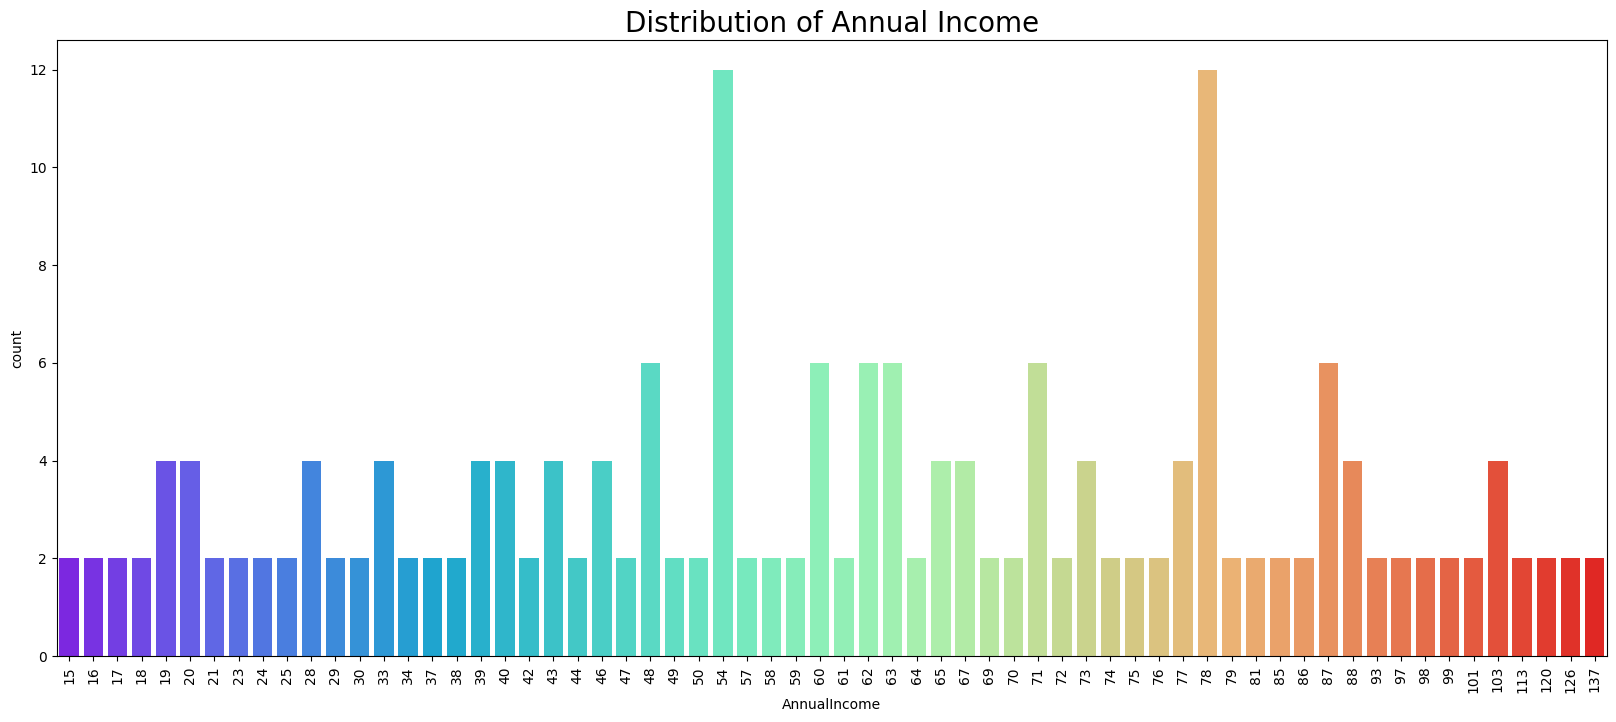

In [9]:
plt.figure(figsize=(20,8),dpi=100)
sns.countplot(data=df, x='AnnualIncome', palette = 'rainbow')
plt.title('Distribution of Annual Income', fontsize = 20)
plt.xticks(rotation=90);
plt.show()

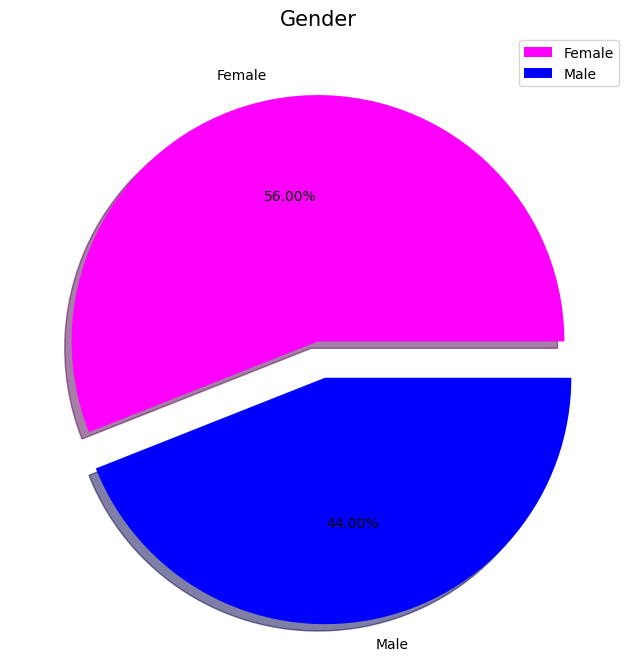

In [10]:
plt.figure(figsize=(8,8))
size = df['Gender'].value_counts()
colors = ['magenta', 'blue']
plt.pie(size, colors = colors, explode = [0, 0.15], labels = ['Female', 'Male'], shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

Gender Vs Annual Income Graph

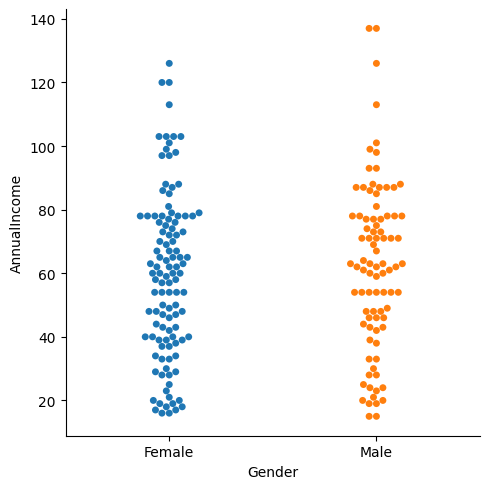

In [11]:
# Categorical Scatterplot on Gender Vs Annual Income
sns.catplot(x="Gender", y="AnnualIncome", kind="swarm",hue="Gender", data=df.sort_values("Gender"))

Categorical attribute Gender

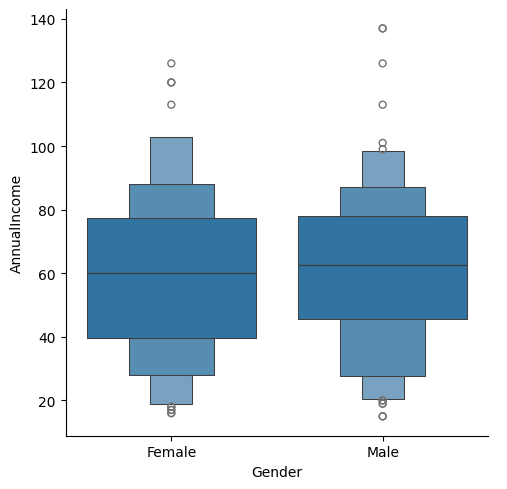

In [12]:
# Distributions of observations within categorical attribute - "Gender"
sns.catplot(x="Gender", y="AnnualIncome", kind="boxen",data=df.sort_values("Gender"))

In the above two plots, Males get paid more than Females. But, at lower annual income level, both genders are paid equally.

Spending Score and Annual Income and gender Graph


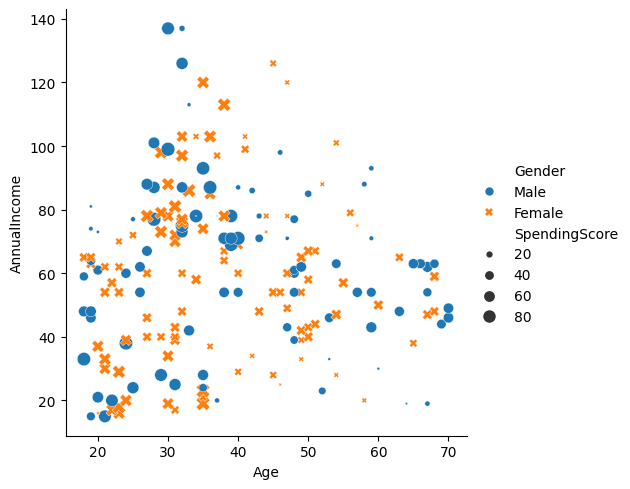

In [13]:
sns.relplot(x="Age", y="AnnualIncome", hue="Gender", style="Gender",size="SpendingScore",sizes=(1, 100), data=df);

In the above graph, It can be seen that the Ages from 30 to 40 has higher annual income and better spending score. Males are heavy spenders then females.<br> Seems like this age group could be the target customers of the mall

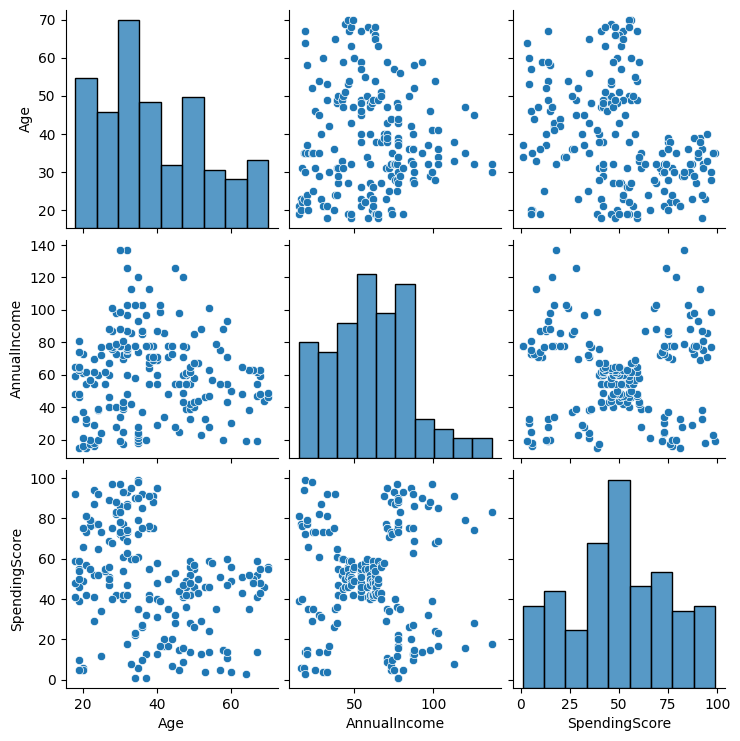

In [14]:
# Data distribution 
sns.pairplot(df);

In the above Plots, we can infer based on the distribution pattern of Annual Income and Age that few people who earn more than 100 US Dollars.Most of the people have an earning of around 25-90 US Dollars. <br>Also, we can say that the least Income is around 20 US Dollars.

People with age,<br> >20 years and < 40 years, have good spending score. Spending score and Annual Income scatter plot is providing us some insight on the clustering.

Variance  of each numerical attribute in the dataset

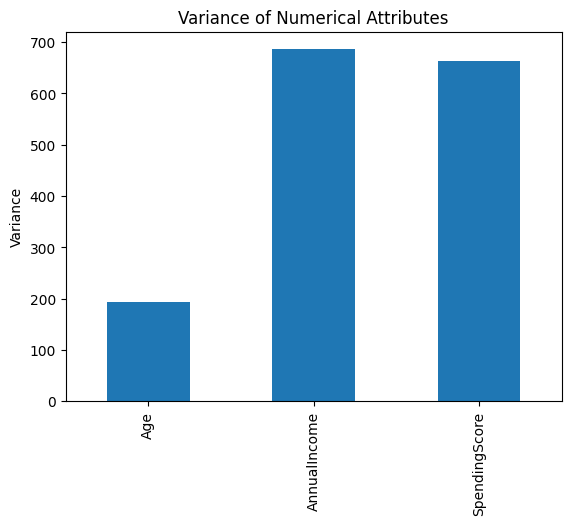

In [15]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number])

# Calculate the variance
variance = numeric_columns.var(ddof=0)

# Plot the variance
variance.plot(kind='bar')
plt.title('Variance of Numerical Attributes')
plt.ylabel('Variance')
plt.show()

**Spending Score and Annual Income**



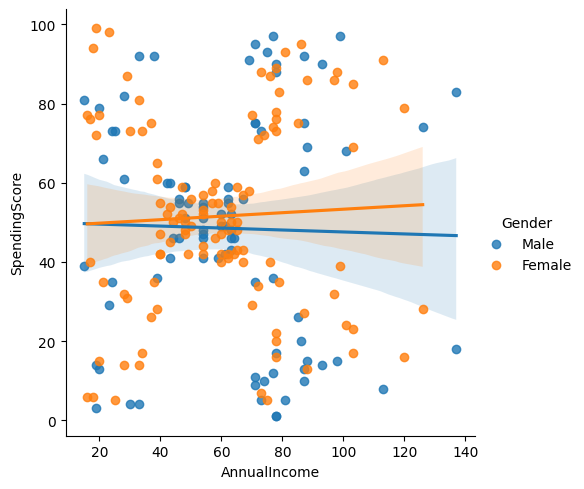

In [16]:
sns.lmplot(x = "AnnualIncome", y = "SpendingScore", data = df, hue = "Gender")

Here we can observe how a better annual income leads to having a higher spending score, specially for women. <br> 

However the correlation between these two variables isn't that big, we seem to find the majority of people in the middle, people who have decent salaries and have a reasonably high spending score.

In [17]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number])

# Calculate the standard deviation
std_dev = numeric_columns.std(ddof=0)

# Display the standard deviation
print(std_dev)

Age              13.934041
AnnualIncome     26.198977
SpendingScore    25.758882
dtype: float64


Assumes the low variance features are "noise" and and high variance features are informative.

 In this case, Age has low variance. Again ! lets not draw any conclusions as we have not normalized the dataset.

Data Split: Train / Test

In [18]:
train_X, test_X = train_test_split(df, test_size=0.2, random_state=42)

print(len(train_X), "train +", len(test_X), "test")

160 train + 40 test


In [19]:
# lets take copy of the data 
df2 = train_X.copy()

Prepare the data
The following stages are:

1. Preprocessing.LabelEncoder() - helps normalize labels such that they contain only values between 0 and n_classes-1.
2. StandardScaler - scaling to unit variance (ie Normalizing the data).
3. Principal Component analysis(PCA)- is an unsupervised statistical technique that is used for dimensionality reduction
4. Perform Clustering K means 

LabelEncoder

In [20]:
# Let fit and transform the Gender attribute into numeric
le = LabelEncoder()
le.fit(df2.Gender)

LabelEncoder()

In [21]:
# 0 is Female, 1 is Male
le.classes_

array(['Female', 'Male'], dtype=object)

In [22]:
#update df2 with transformed values of gender
df2.loc[:,'Gender'] = le.transform(df2.Gender)

In [23]:
df2.head(3)

,Gender,Age,AnnualIncome,SpendingScore
79,0,49,54,42
197,1,32,126,74
38,0,36,37,26


StandardScaler<br>
The StandardScaler is a preprocessing technique used in ml to standardize features by removing the mean and scaling to unit variance.

In [24]:
# Create scaler: scaler
scaler = StandardScaler()
scaler.fit(df2)

StandardScaler()

In [25]:
# transform
data_scaled = scaler.transform(df2)
data_scaled[0:3]

array([[-0.87077078,  0.73027906, -0.24190423, -0.37113766],
       [ 1.14840785, -0.50042667,  2.39455436,  0.84383985],
       [-0.87077078, -0.21084885, -0.8644014 , -0.97862642]])

The next step, PCA is sensitive to the scale of features. Hence, we have normalized the data.



**<a>Principal Component Analysis (PCA)**</a>


In [26]:
pca = PCA()

In [27]:
# fit PCA
pca.fit(data_scaled)


PCA()

In [28]:
# PCA features
features = range(pca.n_components_)
features

range(0, 4)

In [29]:
# PCA transformed data
data_pca = pca.transform(data_scaled)
data_pca.shape

(160, 4)

In [30]:
# PCA components variance ratios.
pca.explained_variance_ratio_

array([0.33107688, 0.26720006, 0.22991261, 0.17181045])

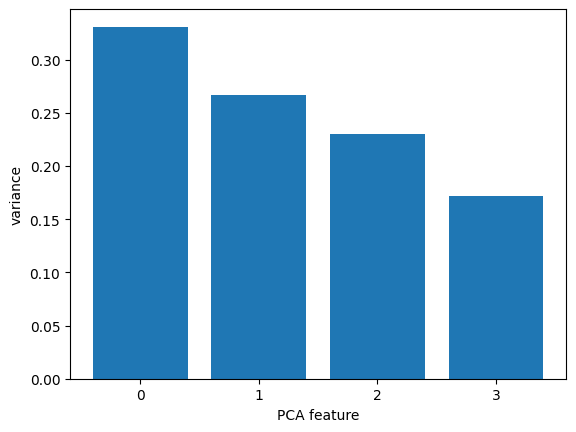

In [31]:
plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

This tells us that 33.2% of the dataset’s variance lies along the first axis, and 26.7% lies along the second axis. WE assumed, 2 Intrinsic dimensions (number of PCA features needed to approximate the dataset) is sufficient to represent dataset in flat 2-dimensional plane.

<a>Principal component analysis (PCA) and singular value decomposition (SVD) </a>

PCA and SVD are closely related approaches and can be both applied to decompose any rectangular matrices.

In [32]:
pca2 = PCA(n_components=2, svd_solver='full')

# fit PCA
pca2.fit(data_scaled)

# PCA transformed data
data_pca2 = pca2.transform(data_scaled)
data_pca2.shape

(160, 2)

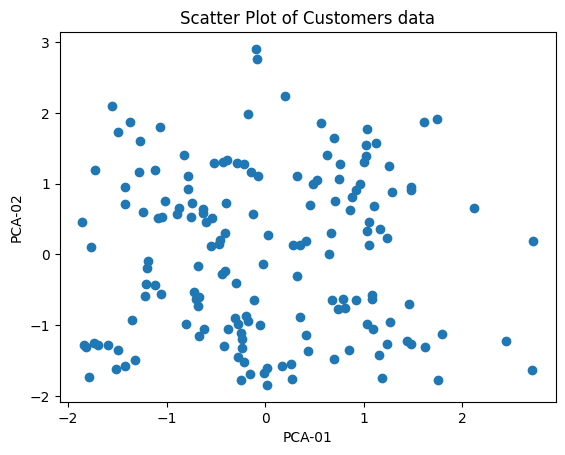

In [33]:
xs = data_pca2[:,0]
ys = data_pca2[:,1]
#zs = train_X.iloc[:,2]
plt.scatter(ys, xs)
#plt.scatter(ys, zs, c=labels)

plt.grid(False)
plt.title('Scatter Plot of Customers data')
plt.xlabel('PCA-01')
plt.ylabel('PCA-02')
plt.show()

In [34]:
# KMeans model
# lets assume 4 clusters to start with
k=4 
kmeans = KMeans(n_clusters=k, init = 'k-means++',random_state = 42) 
# Build pipeline
pipeline = make_pipeline(scaler, pca2, kmeans)
#pipeline = make_pipeline(kmeans)
# fit the model to the scaled dataset
model_fit = pipeline.fit(df2)
model_fit

# target/labels of train_X
labels = model_fit.predict(df2)
labels

# lets add the clusters to the dataset
train_X['Clusters'] = labels
# Number of data points for each feature in each cluster
train_X.groupby('Clusters').count()
     

,Gender,Age,AnnualIncome,SpendingScore
Clusters,,,,
0,28,28,28,28
1,43,43,43,43
2,40,40,40,40
3,49,49,49,49


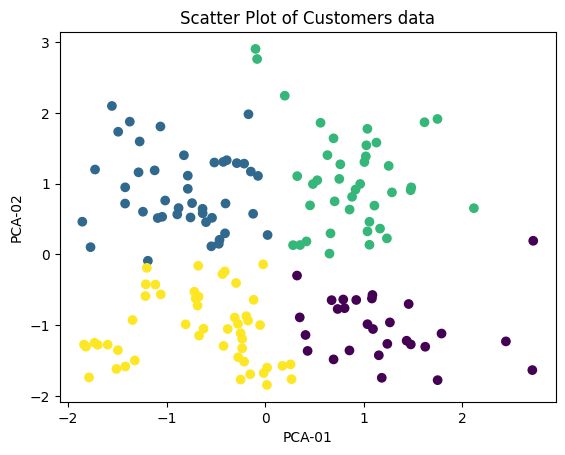

In [35]:
# Scatter plot visuals with labels

xs = data_pca2[:,0]
ys = data_pca2[:,1]
#zs = train_X.iloc[:,2]
plt.scatter(ys, xs,c=labels)
#plt.scatter(ys, zs, c=labels)

plt.grid(False)
plt.title('Scatter Plot of Customers data')
plt.xlabel('PCA-01')
plt.ylabel('PCA-02')

plt.show()